In [20]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'age-gender-and-ethnicity-face-data-csv:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F855240%2F1458546%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240708%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240708T081628Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8c26fc8b773d3f0c7a8d1012fbcbc8f15b6a9b5ff32cc50c91f7e59a4e81b596d60a916b3590d6f34a0d446b5358ac79ae690a7c5e31c05a627bf93beea292a02f04ebb1d1d39c0a335216076b13c7419d7de1ab559eaefb206f9c92f9734a1cba10e5bc7bfff65e165f66ce6d9d4e970b4288c09ba8a704e40014211fa3d15f6d9d02a9d5ba183bb0c9277369c5c07ff085161664ab1d173bc5af0a28835d65822544cfacb4fb743d417c02f880364d4e5bcaa5fa184db5702bc37b9aa1b3bd55a5340455d34e6d15c600bf61969584891abd49eea5a671c8409399a922a68ec8e7de04eadf1504205792a1b43826391878563b00e5d47b921a3c665f2f4592'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 66303838 bytes downloaded
Downloaded and uncompressed: age-gender-and-ethnicity-face-data-csv
Data source import complete.


In [21]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [22]:
df=pd.read_csv('/kaggle/input/age-gender-and-ethnicity-face-data-csv/age_gender.csv')
df

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...
...,...,...,...,...,...
23700,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...


In [23]:
df.shape

(23705, 5)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [25]:
df.isnull().sum() # check missing values

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

In [26]:
df.duplicated().sum()

0

In [27]:
df.dtypes

age           int64
ethnicity     int64
gender        int64
img_name     object
pixels       object
dtype: object

In [28]:
## Converting pixels into numpy array
df['pixels']=df['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

In [29]:
df.dtypes

age           int64
ethnicity     int64
gender        int64
img_name     object
pixels       object
dtype: object

In [30]:
df["ethnicity"].unique()

array([2, 3, 4, 0, 1])

In [31]:
df["gender"].unique()

array([0, 1])

In [32]:
df["age"].unique() #1-99

array([  1,  10, 100, 101, 103, 105,  11, 110, 111, 115, 116,  12,  13,
        14,  15,  16,  17,  18,  19,   2,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,   3,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,   4,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
         5,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,   6,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,   7,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,   8,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,   9,  90,  91,  92,  93,  95,  96,  99])

In [33]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [34]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [35]:
class FaceDataset(Dataset):

    def __init__(self, data_set):

        self.data_set = data_set
        self.transform = transforms.Compose([transforms.ToTensor()]) # convert the image to a PyTorch tensor

    def __len__(self):
        return len(self.data_set) # return the length of the dataset (number of samples in the data_set.)

    def __getitem__(self, i): #index
        if torch.is_tensor(i):
            i = i.tolist()
        #reitive the data
        age = self.data_set['age'].iloc[i]
        ethnicity = self.data_set['ethnicity'].iloc[i]
        gender = self.data_set['gender'].iloc[i]

        pixels = self.data_set['pixels'].iloc[i]
        pixels = np.array(pixels.tolist()) #converted to a numpy array.
        pixels = pixels.reshape(48,48)/255 #normlise
        pixels = np.array(pixels, 'float32')

        pixels = self.transform(pixels) # The pixel array is then converted to a PyTorch tensor

        sample = {'image': pixels, 'age': age, 'ethnicity': ethnicity, 'gender':gender}

        return sample

In [36]:
train_dataset = FaceDataset(train_data)
test_dataset = FaceDataset(test_data)

In [37]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

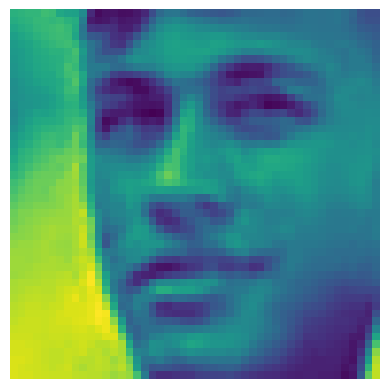

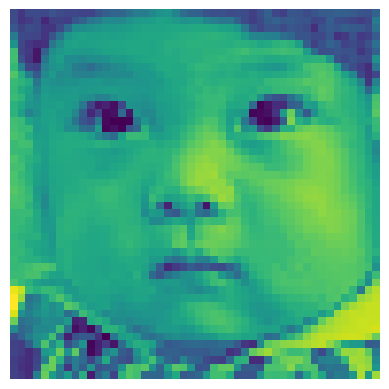

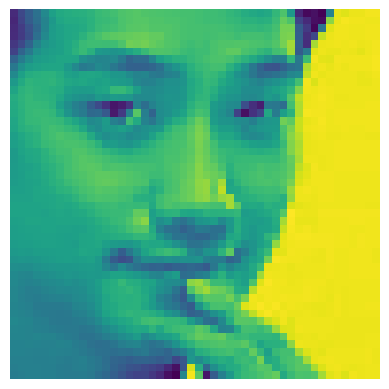

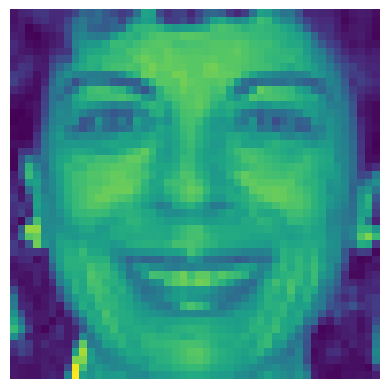

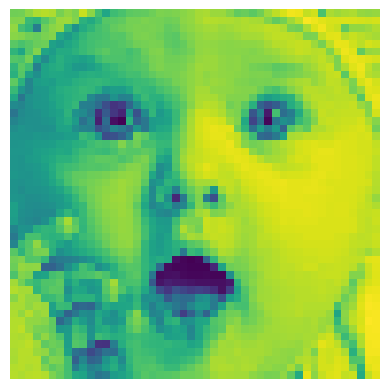

In [39]:
import torch
import matplotlib.pyplot as plt

num_images_to_visualize = 5  # Specify the number of images to visualize

# Iterate over the DataLoader
for batch in test_dataloader:
    images = batch['image']  # Assuming the key for the image tensor is 'image'

    # Iterate over the images in the batch
    for i in range(min(num_images_to_visualize, len(images))):
        image = images[i]  # Get the specific image from the batch

        # Convert the image tensor to a numpy array
        image_np = image.permute(1, 2, 0).numpy() #(C, H, W), where: C: Number of channels (e.g., 3 for RGB images) H: Height of the image W: Width of the image

        # Display the image using matplotlib
        plt.imshow(image_np)
        plt.axis('off')  # Remove axis ticks and labels
        plt.show()

        num_images_to_visualize -= 1  # Decrement the count of remaining images to visualize
        if num_images_to_visualize == 0:
            break  # Stop further visualization if the desired number of images is reached